In [150]:
import numpy as np
import matplotlib.pyplot as plt
import field
import spatial
import timesteppers
import scipy.sparse.linalg as spla
from scipy.integrate import trapz
from scipy import sparse
import scipy.signal as signal

from timesteppers import *

from field import *
from spatial import FiniteDifferenceUniformGrid

# 
%matplotlib inline

In [2]:
def plot_2D_field(xm, ym, data):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    pcm = ax.pcolormesh(xm, ym, data)
    ax.set_aspect(1)
    fig.colorbar(pcm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

In [58]:
def axslice(axis, start, stop, step=None):
    """Slice array along a specified axis."""
    if axis < 0:
        raise ValueError("`axis` must be positive")
    slicelist = [slice(None)] * axis
    slicelist.append(slice(start, stop, step))
    return tuple(slicelist)

In [115]:
class BoundaryCondition(field.LinearOperator):

    def __init__(self, derivative_order, convergence_order, arg, value, axis=0):

        self.derivative_order = derivative_order
        self.convergence_order = convergence_order
        self.dof = self.derivative_order + self.convergence_order
        self.value = value
        self.axis = axis
        self.grid = arg.domain.grids[axis]
        if not isinstance(self.grid, field.UniformNonPeriodicGrid):
            raise ValueError("Can only apply BC's on UniformNonPeriodicGrid")
        self._build_vector()
        N = self.grid.N
        self.matrix = self.vector.reshape((1,N))
        super().__init__(arg)

    def _coeffs(self, dx, j):
        i = np.arange(self.dof)[:, None]
        j = j[None, :]
        S = 1/factorial(i)*(j*dx)**i

        b = np.zeros( self.dof )
        b[self.derivative_order] = 1.

        return np.linalg.solve(S, b)
        
    def field_coeff(self, field, axis=None):
        if axis == None:
            axis = self.axis
        if axis != self.axis:
            raise ValueError("Axis must match self.axis")
        if field == self.field:
            return self.matrix
        else:
            return 0*self.matrix
        
        
class Left(BoundaryCondition):

    def _build_vector(self):
        dx = self.grid.dx
        j = 1/2 + np.arange(self.dof)
        
        coeffs = self._coeffs(dx, j)
        
        self.vector = np.zeros(self.grid.N)
        self.vector[:self.dof] = coeffs
        
    def operate(self):
        s = axslice(self.axis, 1, None)
        BC = self.value - apply_matrix(self.matrix[:,1:], self.field.data[s], self.axis)
        BC /= self.matrix[0,0]
        s = axslice(self.axis, 0, 1)
        self.field.data[s] = BC

        
class Right(BoundaryCondition):

    def _build_vector(self):
        dx = self.grid.dx
        j = np.arange(self.dof) - self.dof + 1/2
        
        coeffs = self._coeffs(dx, j)
        
        self.vector = np.zeros(self.grid.N)
        self.vector[-self.dof:] = coeffs
        
    def operate(self):
        s = axslice(self.axis, None, -1)
        BC = self.value - apply_matrix(self.matrix[:,:-1], self.field.data[s], self.axis)
        BC /= self.matrix[0,-1]
        s = axslice(self.axis, -1, None)
        self.field.data[s] = BC

In [2]:
class DiffusionBC:
    
    def __init__(self, X, nu):
        axis = 0
        self.X = X
        u = X.field_list[0]
        self.domain = u.domain
        
        dudx2 = spatial.FiniteDifferenceUniformGrid(2, 4, u)
        
        ut = field.Field(self.domain)
        
        eq1 = ut - nu*dudx2
        
        bc1 =  Left(0, 4, u, 0)
        bc2 = Right(0, 4, u, 0)
        
        M = eq1.field_coeff(ut, axis=axis)
        M = M.tocsr()
        M[:1,:]  = bc1.field_coeff(ut)
        M[-1:,:] = bc2.field_coeff(ut)
        M.eliminate_zeros()
        self.M = M
        
        L = eq1.field_coeff(u, axis=axis)
        L = L.tocsr()
        L[:1,:]  = bc1.field_coeff(u)
        L[-1:,:] = bc2.field_coeff(u)
        L.eliminate_zeros()
        self.L = L

In [53]:
N = 100
grid = field.UniformNonPeriodicGrid(N,(0,2*np.pi))
domain = field.Domain([grid])
x = grid.values

u = field.Field(domain)
X = field.FieldSystem([u])
nu = 1e-1


### Elapsed time =  1.8527467250823975


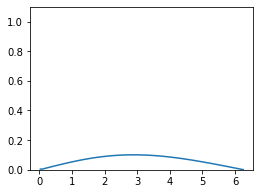

In [54]:
import time
START = time.time()
diffBC = DiffusionBC(X, nu)
IC = np.exp(-(x-np.pi/2)**2*2)
u.data[:] = IC
alpha = 0.5
dt = alpha*grid.dx
ts = timesteppers.CrankNicolson(diffBC,axis='full')

output_cadence = 10
fig = plt.figure(figsize=(4,3))
plt.ylim([0,1.1])
p, = plt.plot(x, u.data)
fig.canvas.draw()
while ts.t < 40-1e-5:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(u.data)
        fig.canvas.draw()
        
END = time.time()
print("### Elapsed time = ",END-START) 

In [189]:
'''class FP_diffusion:
    
    def __init__(self, X, dx2):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain
        
        pt = Field(self.domain)
        
        LHS = pt - dx2 
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
               
class FP_drift:
    
    def __init__(self, X, dx):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain

        pt = Field(self.domain)
        
        LHS = pt + dx 
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
'''    

class FokkerPlanck_1D:
    
    def __init__(self, X, mu, D, spatial_order=4):
      
        self.X = X
        p = self.X.field_list[0]
        self.domain = p.domain
        
        dx = FiniteDifferenceUniformGrid(1, spatial_order, p*mu)
        dx2 = FiniteDifferenceUniformGrid(2, spatial_order, p*D)
        
        #self.operators = [FP_drift(X, dx),
        #                  FP_diffusion(X, dx2)] 
        
        pt = Field(self.domain)
        LHS = pt + dx - dx2
        #self.M = LHS.field_coeff(pt)
        #self.L = LHS.field_coeff(p)

        
        
        bc1 =  Left(0, 4, p, 0)
        bc2 = Right(0, 4, p, 0)
        
        M = LHS.field_coeff(pt)
        M = M.tocsr()
        M[:1,:]  = bc1.field_coeff(pt)
        M[-1:,:] = bc2.field_coeff(pt)
        M.eliminate_zeros()
        self.M = M

        ## M ~ (50, 50), M[0] = [[m0, m1, m2, m3, m4, ...]]
        ## bc1.field_coeff = [0.25, 0.5, 0.25, 0 , 0, 0, 0 , 0 ] ### 
        ### bc1.field_coeff = [0.25, 0.5, 0.25, 0, 0, 0, ..., 0.25, 0.5, 0.25, 0, 0, 0, 0, ...
        
        
        
        L = LHS.field_coeff(p)
        L = L.tocsr()
        L[:1,:]  = bc1.field_coeff(p)
        L[-1:,:] = bc2.field_coeff(p)
        L.eliminate_zeros()
        self.L = L
        
        self.ts = CrankNicolson(self, axis=0)
            
        #self.ts_list   = [CrankNicolson(self.operators[0],axis=0),
        #                  CrankNicolson(self.operators[1],axis=0)]     
        
        self.t = 0.
        self.iter = 0
        
    def step(self, dt):

        self.ts.step(dt)
        #self.ts_list[1].step(dt)
        #self.ts_list[0].step(dt)
        #self.ts_list[0].step(dt/2.)
        self.t += dt
        self.iter += 1

/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


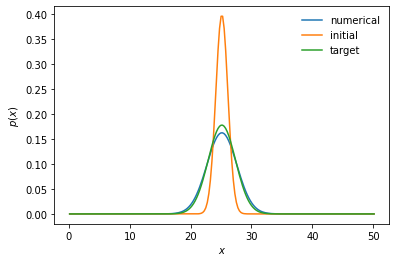

In [190]:
resolution = 200
alpha = .4
spatial_order = 4

grid = field.UniformNonPeriodicGrid(resolution,[0,16*np.pi])
domain = field.Domain([grid])
x = domain.values()

p = field.Field(domain)
X = field.FieldSystem([p])
r = np.array([x])-np.pi

t0 = 1.0
IC = Wiener_sol(0.5, t0, 0, x[0],8*np.pi)

p.data[:]=IC
gamma=0
D = field.Array(domain,0.5*np.ones(p.data.shape))

mu= field.Array(domain,domain.grids[0].values*(gamma))

diff = FokkerPlanck_1D(X,mu,D)

tmax = 5-1e-5

dt = alpha * grid.dx

while diff.t < tmax:
    diff.step(dt)
    
def Wiener_sol(D,t,t0,x,x0):
    sol = 1/(np.sqrt(4*np.pi*D*(t-t0)))*np.exp(-1*(x-x0)**2/(4*D*(t-t0)))
    
    return sol

target = Wiener_sol(0.5,diff.t+t0,t0,x[0],8*np.pi)


plt.plot(x[0],p.data,label='numerical')
plt.plot(x[0],IC,label='initial')
plt.plot(x[0],target,label='target')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.legend(frameon=False)

(200,) (200,)


/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


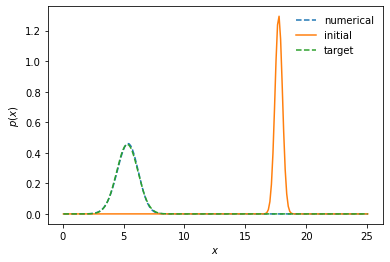

In [131]:

resolution = 200
alpha = .4
spatial_order = 4

grid = field.UniformNonPeriodicGrid(resolution,[0,8*np.pi])
domain = field.Domain([grid])
x, = domain.values()

p = field.Field(domain)
X = field.FieldSystem([p])

def ornstein_uhlenbeck_sol(gamma,D,mu,t,x,x0):
    a = np.sqrt(gamma/(2*np.pi*D*(1-np.exp(-2*gamma*(t))))) 
    b = np.exp(-1*(gamma*(x-np.exp(-gamma*t)*x0)**2)/(2*D*(1-np.exp(-2*gamma*t))))
    return a * b

gamma = 0.6
D = 0.5
mu = gamma * x

x0 = 6*np.pi
t0 = 0.1
ou_IC     = ornstein_uhlenbeck_sol(gamma,D,mu,t0,x,x0)





p.data[:]=ou_IC

D_Arr  = field.Array(domain,D*np.ones(p.data.shape))

mu_Arr = field.Array(domain, -mu)

print(D_Arr.data.shape, mu_Arr.data.shape)


diff = FokkerPlanck_1D(X,mu_Arr,D_Arr)

tmax = 2-1e-5

dt = alpha * grid.dx

while diff.t < tmax:
    diff.step(dt)

    
target_ou = ornstein_uhlenbeck_sol(gamma,D,mu,diff.t+t0,x,x0)

plt.plot(x,p.data,label='numerical',ls='--')
plt.plot(x,ou_IC,label='initial',ls='-')
plt.plot(x,target_ou,label='target',ls='--')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.legend(frameon=False)

### $\frac{dp}{dt} = -\sum \frac{\partial(\mu p)}{\partial x_i} + \sum \frac{\partial^2(Dp)}{\partial x_i \partial x_j}$

In [246]:
class FokkerPlanck_2D:
    
    def __init__(self, X,mu,D, spatial_order=4):
      
     
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain
        
        pt = Field(self.domain)
                             
        dx_pmu = FiniteDifferenceUniformGrid(1, spatial_order, mu*p, axis=0)
        dy_pmu = FiniteDifferenceUniformGrid(1, spatial_order, mu*p, axis=1)
        
        dxx_pD = FiniteDifferenceUniformGrid(2, spatial_order, D*p,   axis = 0)
        dyy_pD = FiniteDifferenceUniformGrid(2, spatial_order, D*p,   axis = 1)
        dx_pD  = FiniteDifferenceUniformGrid(1, spatial_order, D*p,   axis = 0)
        dxy_pD = FiniteDifferenceUniformGrid(1, spatial_order, dx_pD, axis = 1)
        
        LHS = pt  + dx_pmu -dxx_pD
        #LHS = pt  + dx_pmu + dy_pmu - dxx_pD - dyy_pD - dxy_pD


        axis='full'
        
        #self.M = LHS.field_coeff(pt,axis=axis)
        #self.L = LHS.field_coeff(p,axis=axis)
        
        self.bc1x =  Left(0, spatial_order, p, 0, axis=0)
        self.bc2x = Right(0, spatial_order, p, 0, axis=0)
        self.bc1y =  Left(0, spatial_order, p, 0,axis=1)
        self.bc2y = Right(0, spatial_order, p, 0,axis=1)
        
        
        M = LHS.field_coeff(pt,axis='full')
        M = M.tocsr()
        print("M.shape L x = ", M[:1,:].shape)
        print("M.shape L y = ", M[:,:1].shape)
        print("bc field coeff = ", self.bc1x.field_coeff(pt).shape)
        print("bc field coeff 2 = ", self.bc1y.field_coeff(pt).shape)
        
        
        print(self.bc1x.matrix)
        print(self.bc1x.field_coeff(p))
        print('bc matrix shape = ', self.bc1x.matrix.shape)
        print('bc full matrix shape = ', self.bc1x._full_matrix.A.shape)
        
        #print("M.shape = ", M.shape)
        #print("bc field coeff = ", bc1.field_coeff(p).shape, bc1.field_coeff(p))
        #new_bc = np.reshape(np.repeat(bc1.field_coeff(p), len(p.data), axis=0).flatten(), (1, len(p.data)**2))
        #print("new_bc field coeff = ", new_bc.shape, new_bc)
        bc1x_flat_p  = np.reshape(np.repeat(self.bc1x.field_coeff(p),  len(self.domain.grids[0].values), axis=0).flatten(), (1, np.prod(p.data.shape)))
        bc2x_flat_p  = np.reshape(np.repeat(self.bc2x.field_coeff(p),  len(self.domain.grids[0].values), axis=0).flatten(), (1, np.prod(p.data.shape)))
        bc1x_flat_pt = np.reshape(np.repeat(self.bc1x.field_coeff(pt), len(self.domain.grids[0].values), axis=0).flatten(), (1, np.prod(p.data.shape)))
        bc2x_flat_pt = np.reshape(np.repeat(self.bc2x.field_coeff(pt), len(self.domain.grids[0].values), axis=0).flatten(), (1, np.prod(p.data.shape)))
        bc1y_flat_p  = np.reshape(np.repeat(self.bc1y.field_coeff(p),  len(self.domain.grids[1].values), axis=0).flatten(), (1, np.prod(p.data.shape))).T
        bc2y_flat_p  = np.reshape(np.repeat(self.bc2y.field_coeff(p),  len(self.domain.grids[1].values), axis=0).flatten(), (1, np.prod(p.data.shape))).T
        bc1y_flat_pt = np.reshape(np.repeat(self.bc1y.field_coeff(pt), len(self.domain.grids[1].values), axis=0).flatten(), (1, np.prod(p.data.shape))).T
        bc2y_flat_pt = np.reshape(np.repeat(self.bc2y.field_coeff(pt), len(self.domain.grids[1].values), axis=0).flatten(), (1, np.prod(p.data.shape))).T

        print("new bc field coeff = ")
        for i in range(len(bc1x_flat_p[0])): print(bc1x_flat_p[0][i])
        
        '''M[:1,:]  = bc1x_flat_pt#self.bc1x.field_coeff(pt)
        M[-1:,:] = bc2x_flat_pt#self.bc2x.field_coeff(pt)
        M[:,:1]  = bc1y_flat_pt#self.bc1y.field_coeff(pt)
        M[:,:-1] = bc2y_flat_pt#self.bc2y.field_coeff(pt)
        M.eliminate_zeros()'''
        self.M = M
        
        L = LHS.field_coeff(p,axis='full')
        L = L.tocsr()
        L[:1,:]  = bc1x_flat_p#self.bc1x.field_coeff(p)
        L[-1:,:] = bc2x_flat_p#self.bc2x.field_coeff(p)
        L[:,1:]  = bc1y_flat_p#self.bc1y.field_coeff(p)
        L[:,-1:] = bc2y_flat_p#self.bc2y.field_coeff(p)
        L.eliminate_zeros()
        self.L = L
        
        
        self.t = 0.
        self.iter = 0
        
        
    def step(self, dt):
        
        #self.bc1x.operate()
        #self.bc2x.operate()
        #self.bc1y.operate()
        #self.bc2y.operate()
        
        self.ts = CrankNicolson3(self,axis='full')
        self.ts.step(dt)
        self.t += dt
        self.iter += 1

/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


M.shape L x =  (1, 2500)
M.shape L y =  (2500, 1)
bc field coeff =  (1, 50)
bc field coeff 2 =  (1, 50)
[[ 2.1875 -2.1875  1.3125 -0.3125  0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.    ]]
[[ 2.1875 -2.1875  1.3125 -0.3125  0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.    ]]
bc matrix shape =  (1, 50)
bc full matrix shape =  (50, 2500)
new bc field coeff = 
2.1875000000000013
-2.18

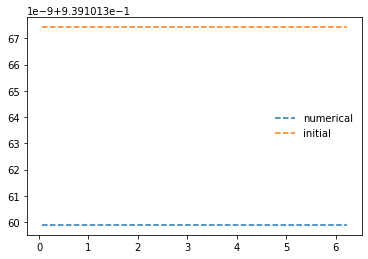

In [247]:
resolution    = 50
alpha         = .1
spatial_order = 4

grid_x = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
grid_y = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
#grid_x=field.UniformPeriodicGrid(resolution,2*np.pi)
#grid_y=field.UniformPeriodicGrid(resolution,2*np.pi)
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()

p = field.Field(domain)
X = field.FieldSystem([p])

mu=field.Array(domain, 0.*np.ones(p.data.shape))
D=field.Array(domain, 0.5*np.ones(p.data.shape))


idx = resolution//2 + 1

#IC=signal.unit_impulse((50,50), 'mid')
#print(IC.shape)
#IC1 = signal.unit_impulse(resolution,'mid')
#IC, IC = np.meshgrid(IC1, IC1)
#IC=IC1[:,None]
#r = x-np.pi
#IC = np.exp(-r**2*8)

#IC = np.exp(-(x-np.pi)**2. - (y-np.pi)**2.)


r = np.sqrt(0*(x-np.pi)**2 + (y-np.pi)**2)
IC = np.exp(-r)#**2/4)


p.data[:]=IC
diff = FokkerPlanck_2D(X,mu,D)

tmax = 0.001-1e-5
dt = alpha * domain.grids[0].dx

while diff.t <tmax: 
    diff.step(dt)
    
plt.plot(x,p.data[:, resolution//2],label='numerical',ls='--')
plt.plot(x,IC[:, resolution // 2],label='initial',ls='--')
plt.legend(frameon=False)

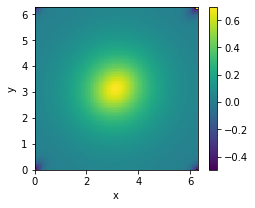

In [208]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
xm, ym = domain.plotting_arrays()
pcm = ax.pcolormesh(xm, ym, p.data)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.canvas.draw()

while diff.t < tmax:
    diff.step(dt)
    if diff.iter % 5 == 0:
        print(diff.iter)
        pcm.set_array(np.ravel(p.data))
        fig.canvas.draw()

In [110]:
N = resolution
idx = resolution//2 + 1
#idx = index at which the value is one (index of x0)
D = .5
tmax = .1-1e-5
x_a = np.linspace(0,2*np.pi,N)
idx = N//2 + 1
Wiener_IC = signal.unit_impulse(N,idx)
x0 = x_a[idx]
t0 = 0
def Wiener_sol(D,t,t0,x,x0):
    sol = 1/(np.sqrt(4*np.pi*D*(t-t0)))*np.exp(-1*(x-x0)**2/(4*D*(t-t0)))
    
    return sol

target = Wiener_sol(D,tmax,t0,x_a,x0)

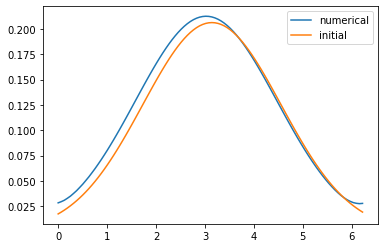

In [113]:
#plt.plot(x_a,target,label='target')
plt.plot(x[:,0],p.data[:,10],label='numerical')
plt.plot(x[:,0],IC[:,10],label='initial')
plt.legend()

In [94]:
resolution = 50
alpha = .4
spatial_order = 4

#grid_x = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
#grid_y = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
grid_x=field.UniformPeriodicGrid(N,2*np.pi)
grid_y=field.UniformPeriodicGrid(N,2*np.pi)
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()

p = field.Field(domain)
X = field.FieldSystem([p])
r = x-np.pi
gamma=1
#mu=field.Array(domain, 0*np.ones(p.data.shape))

#mu= field.Array(domain,domain.grids[0].values*(gamma))
#mu= field.Array(domain,x*y*(gamma))

x2, y2 = np.meshgrid(x, x)
#print(X)

mu= field.Array(domain,x2*(gamma))

D=field.Array(domain, .3*np.ones(p.data.shape))

#print(mu.data)
#print(D.data)
idx=resolution//2+1

r = np.sqrt((x-np.pi)**2 + (y-np.pi)**2)
IC = np.exp(-r**2/4)
#IC = signal.unit_impulse(resolution,idx)
#IC = np.exp(-r**2*8)
#IC=IC[:,None]

#print(IC.shape)
#print(p.data[:,20].shape)
#print(IC[:,None].shape)

In [95]:
p.data[:]=IC
print(p.data.shape)
print(IC.shape)

diff = FokkerPlanck_2D(X,mu,D)

tmax = 2-1e-5

dt = alpha * domain.grids[0].dx
import time
START = time.time()

while diff.t < tmax:
    diff.step(dt)
    
    
END = time.time()
print("### Elapsed time1 = ",END-START) 

(100, 100)
(100, 100)


/home/fulya/packages/anaconda3/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Elapsed time1 =  11.88860559463501


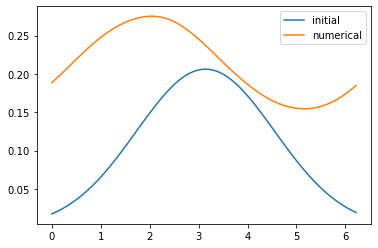

In [96]:
#plt.plot(x_a,target_ou,label='target')

plt.plot(x[:,0],IC[:,10],label='initial')
plt.plot(x[:,0],p.data[:,40],label='numerical')
plt.legend()

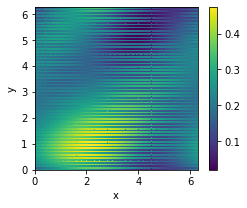

In [97]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
xm, ym = domain.plotting_arrays()
pcm = ax.pcolormesh(xm, ym, p.data)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.canvas.draw()
while diff.t < tmax:
    diff.step(dt)
    if diff.iter % 50 == 0:
        pcm.set_array(np.ravel(p.data))
        fig.canvas.draw()

In [98]:
resolution = 100
alpha = .4
spatial_order = 4

#grid_x = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
#grid_y = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
grid_x=field.UniformPeriodicGrid(N,2*np.pi)
grid_y=field.UniformPeriodicGrid(N,2*np.pi)
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()

p = field.Field(domain)
X = field.FieldSystem([p])
r = x-np.pi
gamma=1
#mu=field.Array(domain, 0*np.ones(p.data.shape))

#mu= field.Array(domain,domain.grids[0].values*(gamma))
#mu= field.Array(domain,x*y*(gamma))

x2, y2 = np.meshgrid(x, x)
#print(X)

D=field.Array(domain, .3*np.ones(p.data.shape))
mu= field.Array(domain,(x2+y2)*(gamma))
#print(mu.data)

#print(D.data)
#idx=resolution//2+1
#IC = signal.unit_impulse(resolution,idx)
IC = np.exp(-r**2*8)
#IC=IC[:,None]

In [99]:
p.data[:]=IC
print(p.data.shape)
print(IC.shape)

diff = FokkerPlanck_2D(X,mu,D)

tmax = 1-1e-5

dt = alpha * domain.grids[0].dx
import time
START = time.time()

while diff.t < tmax:
    diff.step(dt)
    
    
END = time.time()
print("### Elapsed time1 = ",END-START) 

(100, 100)
(100, 1)


/home/fulya/packages/anaconda3/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Elapsed time1 =  6.14727783203125


In [101]:
resolution = 100
N = resolution
x_a = np.linspace(0,2*np.pi,N)
gamma = 1
D = 0.3
mu = gamma * x_a
ou_IC = signal.unit_impulse(N,idx)
def ornstein_uhlenbeck_sol(gamma,D,mu,t,x,x0):
    a = np.sqrt(gamma/(2*np.pi*D*(1-np.exp(-2*gamma*(t))))) 
    b = np.exp(-1*(gamma*(x-np.exp(-gamma*t)*x0)**2)/(2*D*(1-np.exp(-2*gamma*t))))
    return a * b
target_ou = ornstein_uhlenbeck_sol(gamma,D,mu,tmax,x_a,x0)

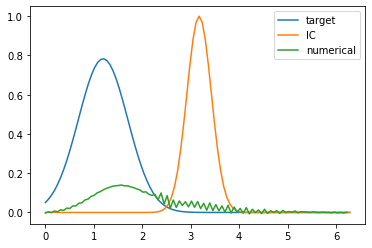

In [102]:
plt.plot(x_a,target_ou,label='target')

plt.plot(x_a,IC,label='IC')
plt.plot(x[:,0],p.data[:,40],label='numerical')
plt.legend()

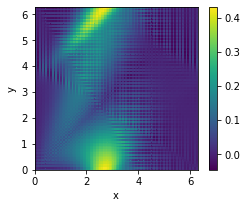

In [103]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
xm, ym = domain.plotting_arrays()
pcm = ax.pcolormesh(xm, ym, p.data)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.canvas.draw()
while diff.t < tmax:
    diff.step(dt)
    if diff.iter % 50 == 0:
        pcm.set_array(np.ravel(p.data))
        fig.canvas.draw()

In [104]:
resolution = 50
alpha = .4
spatial_order = 4

#grid_x = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
#grid_y = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
grid_x=field.UniformPeriodicGrid(N,2*np.pi)
grid_y=field.UniformPeriodicGrid(N,2*np.pi)
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()

p = field.Field(domain)
X = field.FieldSystem([p])
r = x-np.pi
gamma=0.5
#mu=field.Array(domain, 0*np.ones(p.data.shape))

#mu= field.Array(domain,domain.grids[0].values*(gamma))
#mu= field.Array(domain,x*y*(gamma))

x2, y2 = np.meshgrid(x, x)
#print(X)

mu= field.Array(domain,np.sin(x2)*y2*(gamma))

D=field.Array(domain, y2**3*gamma)

#print(mu.data)
#print(D.data)
idx=resolution//2+1

r = np.sqrt((x-np.pi)**2 + (y-np.pi)**2)
IC = np.exp(-r**2/4)
#IC = signal.unit_impulse(resolution,idx)
#IC = np.exp(-r**2*8)
#IC=IC[:,None]

#print(IC.shape)
#print(p.data[:,20].shape)
#print(IC[:,None].shape)

In [105]:
p.data[:]=IC
print(p.data.shape)
print(IC.shape)

diff = FokkerPlanck_2D(X,mu,D)

tmax = 2-1e-5

dt = alpha * domain.grids[0].dx
import time
START = time.time()

while diff.t < tmax:
    diff.step(dt)
    
    
END = time.time()
print("### Elapsed time1 = ",END-START) 

(100, 100)
(100, 100)


/home/fulya/packages/anaconda3/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Elapsed time1 =  29.95839762687683


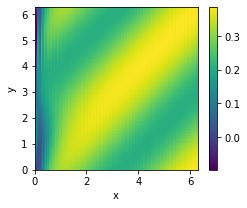

In [106]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
xm, ym = domain.plotting_arrays()
pcm = ax.pcolormesh(xm, ym, p.data)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.canvas.draw()
while diff.t < tmax:
    diff.step(dt)
    if diff.iter % 50 == 0:
        pcm.set_array(np.ravel(p.data))
        fig.canvas.draw()